**Соревнование**
https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pylab as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Embedding, LSTM
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn import metrics
from sklearn import ensemble
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from keras.optimizers import RMSprop 
from keras.utils import plot_model
import matplotlib.pyplot as plt1

## Считывание датасетов и их первичный осмотр
Рассмотрим каждый файл датасета, которые понадобятся нам для обучения моделей.

In [ ]:
data_sales = pd.read_csv('sales_train.csv')
data_items = pd.read_csv('items.csv')
data_cat = pd.read_csv('item_categories.csv')
data_shops = pd.read_csv('shops.csv')

In [ ]:
data_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [ ]:
data_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
data_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [ ]:
data_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [ ]:
data_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
data_shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


Заметим, что датасет data_sales несет основную признаковыю нагрузку для задачи, остальные являются пояснительными таблицами. Но в data_sales есть пропущенный столбец item_categori_id, добавим его в новый датасет data.

In [ ]:
data = data_sales.merge(data_items, how='left').drop('item_name', axis=1)

In [ ]:
data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


Проверим, всем ли объектам добавилась категория.

In [ ]:
data['item_category_id'].isnull().value_counts()

False    2935849
Name: item_category_id, dtype: int64

Как можно заметить объединение прошло успешно, теперь используем инструменты визуализации и рассмотрим признаки объектов. Начнем с объемной визуализации попарных зависимостей. Для дальнейших более удобных сравнений признаков переведем столбец date в формат int.

Выыедем основные статистические показатели датасета.

In [ ]:
data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


Заметим, что в целевом признаке есть отрицательный значения, отдельно рассмотрим их.

In [ ]:
answers = data['item_cnt_day'].value_counts()
print(answers.idxmin())
print(np.sort(answers.index))

-22.0
[-2.200e+01 -1.600e+01 -9.000e+00 -6.000e+00 -5.000e+00 -4.000e+00
 -3.000e+00 -2.000e+00 -1.000e+00  1.000e+00  2.000e+00  3.000e+00
  4.000e+00  5.000e+00  6.000e+00  7.000e+00  8.000e+00  9.000e+00
  1.000e+01  1.100e+01  1.200e+01  1.300e+01  1.400e+01  1.500e+01
  1.600e+01  1.700e+01  1.800e+01  1.900e+01  2.000e+01  2.100e+01
  2.200e+01  2.300e+01  2.400e+01  2.500e+01  2.600e+01  2.700e+01
  2.800e+01  2.900e+01  3.000e+01  3.100e+01  3.200e+01  3.300e+01
  3.400e+01  3.500e+01  3.600e+01  3.700e+01  3.800e+01  3.900e+01
  4.000e+01  4.100e+01  4.200e+01  4.300e+01  4.400e+01  4.500e+01
  4.600e+01  4.700e+01  4.800e+01  4.900e+01  5.000e+01  5.100e+01
  5.200e+01  5.300e+01  5.400e+01  5.500e+01  5.600e+01  5.700e+01
  5.800e+01  5.900e+01  6.000e+01  6.100e+01  6.200e+01  6.300e+01
  6.400e+01  6.500e+01  6.600e+01  6.700e+01  6.800e+01  6.900e+01
  7.000e+01  7.100e+01  7.200e+01  7.300e+01  7.400e+01  7.500e+01
  7.600e+01  7.700e+01  7.800e+01  7.900e+01  8.000e+01 

Как можно заметить, количество проданных товаров в датасете может быть и отрицательным числом, для дальнейшего решения задачи лучше ити данные убрать, так как они создают неопределенность в интерпретации подобных явлений, найдем количество таких объектов.

In [ ]:
data[data['item_cnt_day'] < 0].shape

(7356, 7)

Таких записей всего лишь 7000, на фоне более 2000000 записей это составляет менее половины процента объектов, поэтому просто удалим такие записи.

In [ ]:
data = data[data['item_cnt_day'] > 0]

## Визуализация данных

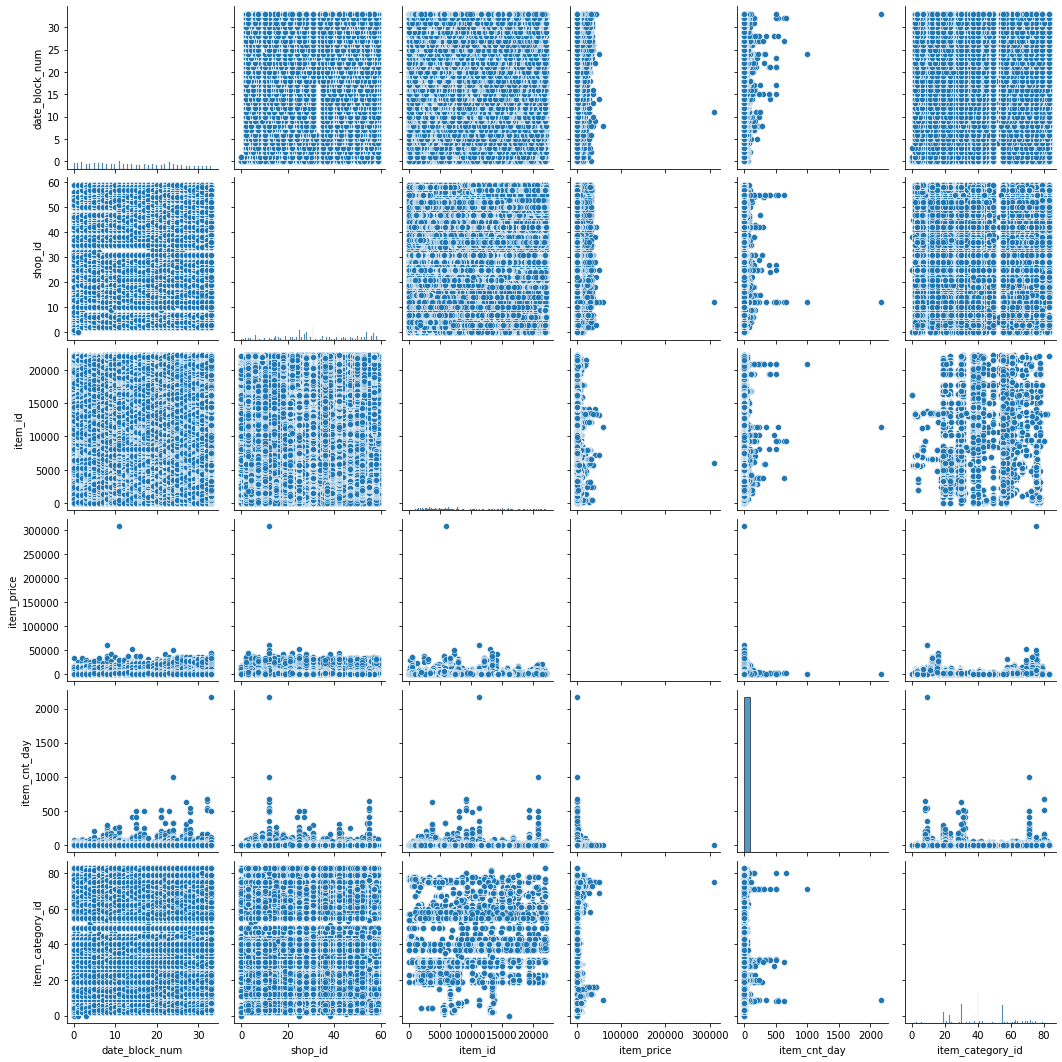

In [ ]:
sns.pairplot(data)

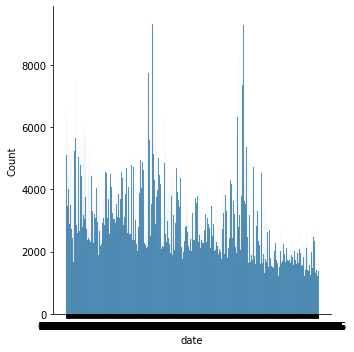

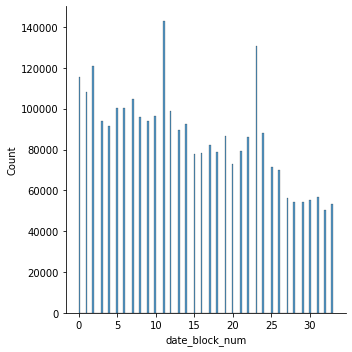

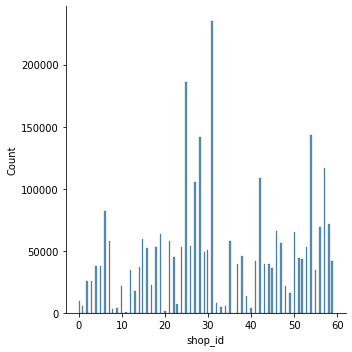

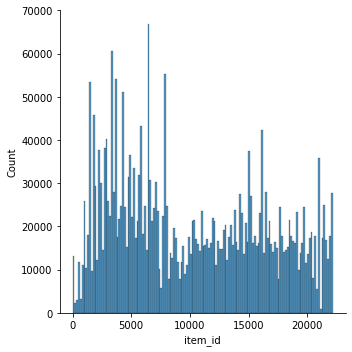

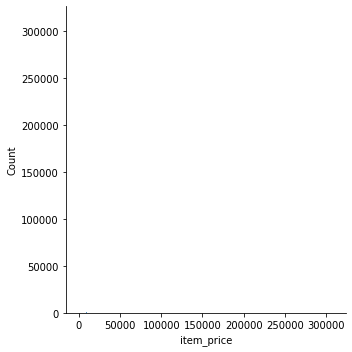

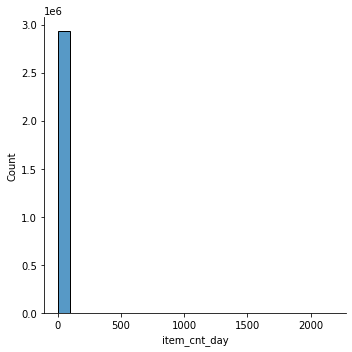

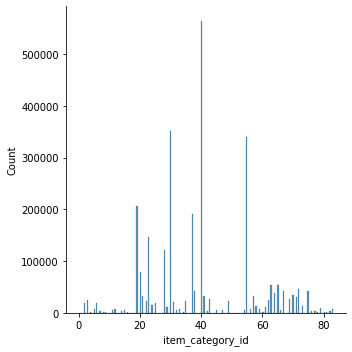

In [ ]:
#fig, axes = plt.subplots(7, 1, figsize=(20, 30));
for i in range(len(data.columns)):
  sns.displot(data, x=data.columns[i] )

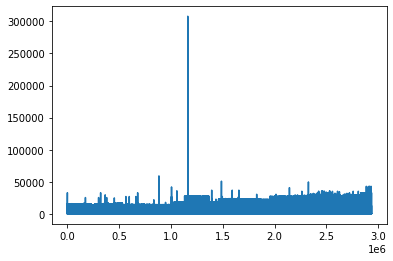

In [ ]:
data['item_price'].plot()

Представив распределение всех признаков можно заметить, что явных выбросов не наблюдается, единственно есть разряженность в признаке категории товара

Теперь попробуем найти зависимости признаков к целевому признаку.

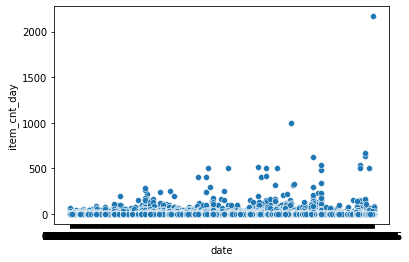

In [ ]:
sns.scatterplot(x=data['date'], y=data['item_cnt_day'])

По графику видим небольшую линейную зависимость целевого признака от даты в сторону возрастания.

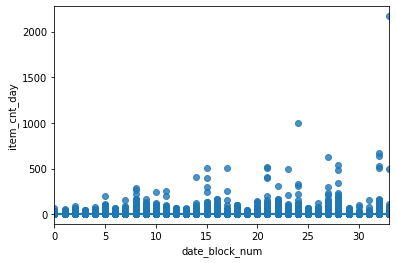

In [ ]:
sns.regplot(x=data['date_block_num'], y=data['item_cnt_day'])

Заметна аналогичная ситуация как и с датой.

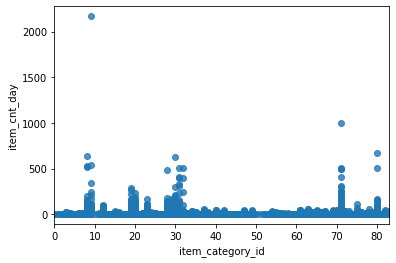

In [ ]:
sns.regplot(x=data['item_category_id'], y=data['item_cnt_day'])

ПО графику видно, что некоторые категории покупаются намного чаще остальных.

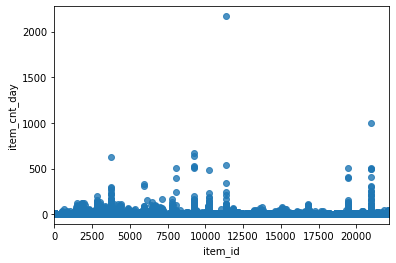

In [ ]:
sns.regplot(x=data['item_id'], y=data['item_cnt_day'])

Аналогично, с предыдущим графиком, некоторые товары более рентабельны.

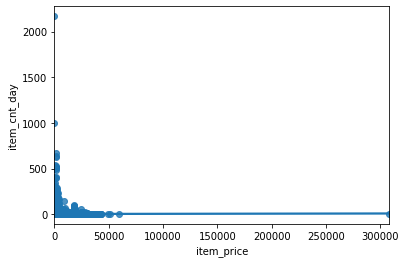

In [ ]:
sns.regplot(x=data['item_price'], y=data['item_cnt_day'])

Заметна обратная зависимость, чем меньше цена на товар тем чаще его покупают.

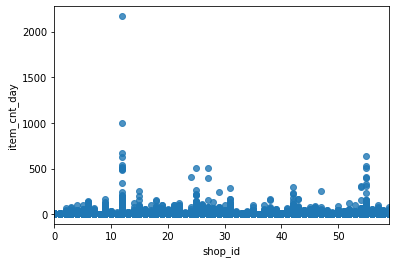

In [ ]:
sns.regplot(x=data['shop_id'], y=data['item_cnt_day'])

По графику видим, что некоторые магазины пользуются большим спросом, чем остальные.

Рассмотрим линейные зависимости признаков и построим heatmap для попарных корреляций между признаками.

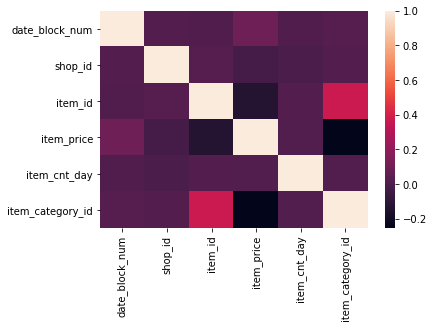

In [ ]:
pivot = data.pivot_table(index=['date_block_num'], columns=['item_category_id'], values='item_cnt_day')
sns.heatmap(data.corr())

Заметим, что все признаки независят друг от друга, за исключением item_id и item_category_id, что имеет смысл, так как примерно одинаковые товарны относятся к одной категории.

## Подготовка датасета

Раздалим датасет на признаковое описание и целевой признак

In [ ]:
X = data.drop('item_cnt_day', axis=1)
y = data['item_cnt_day']

Рассмотрим датасет и выделим в нем категориальные и вещественные признаки

In [ ]:
X.head()

,date,date_block_num,shop_id,item_id,item_price,item_category_id
0,02.01.2013,0,59,22154,999.00,37
1,03.01.2013,0,25,2552,899.00,58
3,06.01.2013,0,25,2554,1709.05,58
4,15.01.2013,0,25,2555,1099.00,56
5,10.01.2013,0,25,2564,349.00,59


Категориальными признаками являются shop_id, item_id, item_categoty_id. И вещественными item_price, date_block_num. Рассмотрим количество значений в категориальных признаках. Кроме того, мы можем из признакового описания удалить признак date, так как нам нужно прогнозировать значения на следующий месяц, а не на конкретную дату, а значение месяца имеется как отдельный признак.

In [ ]:
X = X.drop('date', axis=1)

In [ ]:
print(X['shop_id'].unique())
print(len(X['shop_id'].unique()))

[59 25 24 23 19 22 18 21 28 27 29 26  4  6  2  3  7  0  1 16 15  8 10 14
 13 12 53 31 30 32 35 56 54 47 50 42 43 52 51 41 38 44 37 46 45  5 57 58
 55 17  9 49 39 40 48 34 33 20 11 36]
60


In [ ]:
print(X['item_id'].unique())
print(len(X['item_id'].unique()))

[22154  2552  2554 ...  7610  7635  7640]
21804


In [ ]:
print(X['item_category_id'].unique())
print(len(X['item_category_id'].unique()))

[37 58 56 59 55 23 19 28 30 21 40 75 49 29 22 67 73 77 57 60  4 62 43 15
  2  3  5 68 35 33  6 38 25 14 45 41 66 11 69 65 82 81 64 79 63  0 70 13
 83 72 61 71 18  9 46  1 48 10 31 76 78 54 44 52 32 39 53 12 20 17  8 16
 51 34 24  7 74 26 27 47 50 42 80 36]
84


Получили достаточно много значений в каждом признаке. Кроме того, в столбце item_id количество значений больше 20000, поэтому будем его рассматривать как вещественный признак. Остальные признаки перекодируем one-hot кодировкой.

In [ ]:
X_item_category_id = pd.get_dummies(X['item_category_id'], prefix='item_category_id')
X_item_category_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928493 entries, 0 to 2935848
Data columns (total 84 columns):
 #   Column               Dtype
---  ------               -----
 0   item_category_id_0   uint8
 1   item_category_id_1   uint8
 2   item_category_id_2   uint8
 3   item_category_id_3   uint8
 4   item_category_id_4   uint8
 5   item_category_id_5   uint8
 6   item_category_id_6   uint8
 7   item_category_id_7   uint8
 8   item_category_id_8   uint8
 9   item_category_id_9   uint8
 10  item_category_id_10  uint8
 11  item_category_id_11  uint8
 12  item_category_id_12  uint8
 13  item_category_id_13  uint8
 14  item_category_id_14  uint8
 15  item_category_id_15  uint8
 16  item_category_id_16  uint8
 17  item_category_id_17  uint8
 18  item_category_id_18  uint8
 19  item_category_id_19  uint8
 20  item_category_id_20  uint8
 21  item_category_id_21  uint8
 22  item_category_id_22  uint8
 23  item_category_id_23  uint8
 24  item_category_id_24  uint8
 25  item_category_id_2

In [ ]:
X_shop_id = pd.get_dummies(X['shop_id'], prefix='shop_id')
X_shop_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928493 entries, 0 to 2935848
Data columns (total 60 columns):
 #   Column      Dtype
---  ------      -----
 0   shop_id_0   uint8
 1   shop_id_1   uint8
 2   shop_id_2   uint8
 3   shop_id_3   uint8
 4   shop_id_4   uint8
 5   shop_id_5   uint8
 6   shop_id_6   uint8
 7   shop_id_7   uint8
 8   shop_id_8   uint8
 9   shop_id_9   uint8
 10  shop_id_10  uint8
 11  shop_id_11  uint8
 12  shop_id_12  uint8
 13  shop_id_13  uint8
 14  shop_id_14  uint8
 15  shop_id_15  uint8
 16  shop_id_16  uint8
 17  shop_id_17  uint8
 18  shop_id_18  uint8
 19  shop_id_19  uint8
 20  shop_id_20  uint8
 21  shop_id_21  uint8
 22  shop_id_22  uint8
 23  shop_id_23  uint8
 24  shop_id_24  uint8
 25  shop_id_25  uint8
 26  shop_id_26  uint8
 27  shop_id_27  uint8
 28  shop_id_28  uint8
 29  shop_id_29  uint8
 30  shop_id_30  uint8
 31  shop_id_31  uint8
 32  shop_id_32  uint8
 33  shop_id_33  uint8
 34  shop_id_34  uint8
 35  shop_id_35  uint8
 36  shop_id_

Перед объединением разобьём датасеты на 10 частей, так как записей много для одновременной обработки.

In [ ]:
X_item_category_id_list = []
first = 0
for i in range(1, 11):
  last = int(i/10 * X.shape[0])
  X_item_category_id_list.append(X_item_category_id.iloc[first: last])
  first = last

In [ ]:
X_shop_id_list = []
first = 0
for i in range(1, 11):
  last = int(i/10 * X.shape[0])
  X_shop_id_list.append(X_shop_id.iloc[first: last])
  first = last

Объединение в единий массив производиться не будет, так как происходят большие просадки по памяти, поэтому перейдем к масштабированию двух вещественных признаков.

In [ ]:
scaler = StandardScaler()
scaler.fit(X[['item_id', 'item_price', 'date_block_num']])
X_scaled = scaler.transform(X[['item_id', 'item_price', 'date_block_num']])

Разобьем датасет на столько же частей как и категориальные данные.

In [ ]:
X_scaled_list = []
first = 0
for i in range(1, 11):
  last = int(i/10 * X.shape[0])
  X_scaled_list.append(X_scaled[first: last])
  first = last

Также разобьем на 10 частей целевые признаки

In [ ]:
y_list = []
first = 0
for i in range(1, 11):
  last = int(i/10 * X.shape[0])
  y_list.append(y.iloc[first: last])
  first = last

Дополнительно разбивать выборку на тренировочную и тестовую не будем, в виде тестовой выборки послужит последний элемент в списках признаковых описаний

## Создание модели (нейросеть)
В качестве модели возьмем нейронную сеть с 3 скрытыми слоями, функцией активации relu, функцией потерь mean_absolute_error, и функцией активации выходного слоя linear.

In [ ]:
n_ = np.concatenate([np.array(X_item_category_id_list[0]), np.array(X_shop_id_list[0]), X_scaled_list[0]], axis=1).shape[1]

In [ ]:
model = Sequential()

model.add(Dense(128, input_dim=n_, activation='relu'))

model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               18944     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 183,809
Trainable params: 183,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history1 = []
for i in range(9):
  X_train = np.concatenate([np.array(X_item_category_id_list[i]), np.array(X_shop_id_list[i]), X_scaled_list[i]], axis=1)
  history = model.fit(X_train, y_list[i], epochs=20, batch_size=200)
  history1.append(history)

Epoch 1/20
1465/1465 [==============================] - 17s 2ms/step - loss: 0.2163 - mean_absolute_percentage_error: 9.4984
Epoch 2/20
1465/1465 [==============================] - 4s 2ms/step - loss: 0.1837 - mean_absolute_percentage_error: 6.3927
Epoch 3/20
1465/1465 [==============================] - 3s 2ms/step - loss: 0.1808 - mean_absolute_percentage_error: 6.2317
Epoch 4/20
1465/1465 [==============================] - 4s 2ms/step - loss: 0.1797 - mean_absolute_percentage_error: 6.1237
Epoch 5/20
1465/1465 [==============================] - 4s 2ms/step - loss: 0.1792 - mean_absolute_percentage_error: 6.1294
Epoch 6/20
1465/1465 [==============================] - 3s 2ms/step - loss: 0.1750 - mean_absolute_percentage_error: 5.9331
Epoch 7/20
1465/1465 [==============================] - 3s 2ms/step - loss: 0.1799 - mean_absolute_percentage_error: 6.0770
Epoch 8/20
1465/1465 [==============================] - 3s 2ms/step - loss: 0.1797 - mean_absolute_percentage_error: 6.0607
Epoch 9

In [ ]:
X_test = np.concatenate([np.array(X_item_category_id_list[9]), np.array(X_shop_id_list[9]), X_scaled_list[9]], axis=1)
_, accuracy = model.evaluate(X_test, y_list[9])
print('Mean absolute percentage error: %.2f' % (accuracy))

9152/9152 [==============================] - 15s 2ms/step - loss: 0.2287 - mean_absolute_percentage_error: 5.6135
Mean absolute percentage error: 5.61


Получили ошибку в 5,76 процентов, что является хорошим результатом. Дообучим сеть на оставшемся блоке.

In [ ]:
history = model.fit(X_test, y_list[9], epochs=20, batch_size=200)
history1.append(history)

Epoch 1/20
1465/1465 [==============================] - 3s 2ms/step - loss: 0.2289 - mean_absolute_percentage_error: 5.7208
Epoch 2/20
1465/1465 [==============================] - 4s 2ms/step - loss: 0.2284 - mean_absolute_percentage_error: 5.6898
Epoch 3/20
1465/1465 [==============================] - 3s 2ms/step - loss: 0.2279 - mean_absolute_percentage_error: 5.6455
Epoch 4/20
1465/1465 [==============================] - 4s 2ms/step - loss: 0.2279 - mean_absolute_percentage_error: 5.6566
Epoch 5/20
1465/1465 [==============================] - 3s 2ms/step - loss: 0.2279 - mean_absolute_percentage_error: 5.6610
Epoch 6/20
1465/1465 [==============================] - 3s 2ms/step - loss: 0.2277 - mean_absolute_percentage_error: 5.6584
Epoch 7/20
1465/1465 [==============================] - 3s 2ms/step - loss: 0.2275 - mean_absolute_percentage_error: 5.6560
Epoch 8/20
1465/1465 [==============================] - 3s 2ms/step - loss: 0.2274 - mean_absolute_percentage_error: 5.6612
Epoch 9/

In [ ]:
model.save('drive/MyDrive/model_comp')

INFO:tensorflow:Assets written to: drive/MyDrive/model_comp/assets


In [ ]:
hist = []
for i in range(len(history1)):
  hist = hist + history1[i].history['loss']
plt.plot(hist)
print(hist)
plt1.title('Model loss')
plt1.ylabel('Loss')
plt1.xlabel('Epoch')
plt1.legend(['Train', 'Test'], loc='upper left')
plt1.show()

## Создание модели (2 нейросеть)
Используем рекурентную нейронную сеть

In [ ]:
model3 = Sequential()

model3.add(LSTM(128, input_shape=(1, n_), activation='relu'))
model3.add(Dense(1, activation='linear'))

model3.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               141312    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 141,441
Trainable params: 141,441
Non-trainable params: 0
_________________________________________________________________


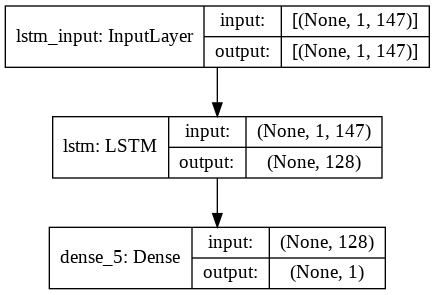

In [ ]:
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history2 = []
for i in range(9):
  X_train = np.concatenate([np.array(X_item_category_id_list[i]), np.array(X_shop_id_list[i]), X_scaled_list[i]], axis=1)
  X_train_ = X_train.reshape(X_train.shape[0], 1, n_)
  history = model3.fit(X_train_, y_list[i], epochs=20, batch_size=200)
  history2.append(history)

Epoch 1/20
1465/1465 [==============================] - 13s 8ms/step - loss: 0.2983 - mean_absolute_percentage_error: 17.5180
Epoch 2/20
1465/1465 [==============================] - 12s 8ms/step - loss: 0.1793 - mean_absolute_percentage_error: 6.0139
Epoch 3/20
1465/1465 [==============================] - 11s 8ms/step - loss: 0.1763 - mean_absolute_percentage_error: 5.9134
Epoch 4/20
1465/1465 [==============================] - 11s 8ms/step - loss: 0.1774 - mean_absolute_percentage_error: 5.9139
Epoch 5/20
1465/1465 [==============================] - 11s 8ms/step - loss: 0.1752 - mean_absolute_percentage_error: 5.8790
Epoch 6/20
1465/1465 [==============================] - 12s 8ms/step - loss: 0.1799 - mean_absolute_percentage_error: 5.9811
Epoch 7/20
1465/1465 [==============================] - 12s 8ms/step - loss: 0.1767 - mean_absolute_percentage_error: 5.9273
Epoch 8/20
1465/1465 [==============================] - 11s 8ms/step - loss: 0.1767 - mean_absolute_percentage_error: 5.9075

In [ ]:
X_test = np.concatenate([np.array(X_item_category_id_list[9]), np.array(X_shop_id_list[9]), X_scaled_list[9]], axis=1)
_, accuracy = model3.evaluate(X_test.reshape(X_test.shape[0], 1, n_), y_list[9])
print('Mean absolute percentage error: %.2f' % (accuracy))

9152/9152 [==============================] - 13s 1ms/step - loss: 0.2507 - mean_absolute_percentage_error: 8.8866
Mean absolute percentage error: 8.89


In [ ]:
history = model3.fit(X_test.reshape(X_test.shape[0], 1, n_), y_list[9], epochs=20, batch_size=200)
history2.append(history)

Epoch 1/20
1465/1465 [==============================] - 12s 8ms/step - loss: 0.2249 - mean_absolute_percentage_error: 6.0225
Epoch 2/20
1465/1465 [==============================] - 12s 8ms/step - loss: 0.2232 - mean_absolute_percentage_error: 5.8855
Epoch 3/20
1465/1465 [==============================] - 11s 8ms/step - loss: 0.2228 - mean_absolute_percentage_error: 5.8769
Epoch 4/20
1465/1465 [==============================] - 12s 8ms/step - loss: 0.2224 - mean_absolute_percentage_error: 5.8702
Epoch 5/20
1465/1465 [==============================] - 12s 8ms/step - loss: 0.2222 - mean_absolute_percentage_error: 5.8669
Epoch 6/20
1465/1465 [==============================] - 12s 8ms/step - loss: 0.2222 - mean_absolute_percentage_error: 5.8600
Epoch 7/20
1465/1465 [==============================] - 11s 8ms/step - loss: 0.2220 - mean_absolute_percentage_error: 5.8543
Epoch 8/20
1465/1465 [==============================] - 12s 8ms/step - loss: 0.2219 - mean_absolute_percentage_error: 5.8646


[0.2085397094488144, 0.17744319140911102, 0.17723186314105988, 0.17716780304908752, 0.17712116241455078, 0.17703558504581451, 0.17701244354248047, 0.17700891196727753, 0.1769561767578125, 0.1769479215145111, 0.17691200971603394, 0.17685222625732422, 0.17685829102993011, 0.17681515216827393, 0.17682211101055145, 0.1767546683549881, 0.17675921320915222, 0.17666736245155334, 0.176755890250206, 0.17666533589363098, 0.17973004281520844, 0.17781013250350952, 0.17664125561714172, 0.17615579068660736, 0.17584319412708282, 0.1755494624376297, 0.1753900647163391, 0.1752076894044876, 0.17506326735019684, 0.17495407164096832, 0.17487198114395142, 0.17478610575199127, 0.17468655109405518, 0.17462392151355743, 0.17451652884483337, 0.1744329333305359, 0.1743585467338562, 0.1743767112493515, 0.17426277697086334, 0.1742534190416336, 0.20286069810390472, 0.1979387402534485, 0.19563014805316925, 0.1945987343788147, 0.19407440721988678, 0.19382378458976746, 0.19369348883628845, 0.19354720413684845, 0.1935

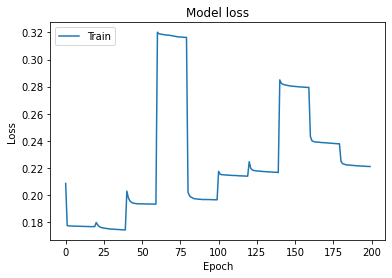

In [ ]:
hist = []
for i in range(len(history1)):
  hist = hist + history2[i].history['loss']
plt.plot(hist)
print(hist)
plt1.title('Model loss')
plt1.ylabel('Loss')
plt1.xlabel('Epoch')
plt1.legend(['Train', 'Test'], loc='upper left')
plt1.show()

## Рассмотрение тестовой выборки
Теперь перед подготовкой тренировочного датасета и моделей, рассмотрим тестовый датасет, чтобы выделить признаки, подающиеся на вход, а также признаки которые возможно восстановить.

In [ ]:
data_test = pd.read_csv('test.csv', index_col=0)

In [ ]:
data_test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


В тестовой выборке на вход подается только id товара и магазина, где произведена покупка. Категорию товара и его цену мы можем восстановить по имеющейся таблице, а месяц взять следующие после тренировочного датасета. Но возникает вопрос, могут ли появится товары которые раньше неучаствовали в продаже или отсутствуют вообще в других датасетах. Для этого сравним уникальные значения датасетов

Сначала рассмотрим наличие предметов ранее не продававшихся.

In [ ]:
item_train_list = set(np.array(data['item_id'].unique()))
item_test_list = set(np.array(data_test['item_id'].unique()))
print(item_test_list.issubset(item_train_list))

False


Получаем, что в тестовой выборке есть предметы не встречавшиеся раньше. Теперь проверим также и магазины.

In [ ]:
shop_train_list = set(np.array(data['shop_id'].unique()))
shop_test_list = set(np.array(data_test['shop_id'].unique()))
print(shop_test_list.issubset(shop_train_list))

True


А магазины в тестовой выборке встречаются те же, что и в тренировочной выборке

Теперь рассмотрим, есть ли новые item_id из тестовой выборки в датасете item.

In [ ]:
unique = item_test_list.difference(item_train_list)
items_set = set(np.array(data_items['item_id'].unique()))
print(unique.issubset(items_set))

True


Получаем, что даже новые элементы находятся в таблице items, значит восстановить категорию элементов возможно, осталась проблема восстановления цены товаров. Так как товар ранее не продавался в этом магазине, то возьмем среднее значение среди последних проданных товаров за месяц из этой категории. А для товаров уже продаваемых ранее возьмем последнюю цену, за которую был продан товар.

In [ ]:
def get_vector(x):
  id = x['item_id']
  cat = data_items[data_items['item_id'] == id]['item_category_id'].max()
  month = data['date_block_num'].max() + 1
  shop = x['shop_id']
  if data[(data['shop_id'] == shop) & (data['item_id'] == id)].shape[0] != 0:
    price = np.array(data[(data['shop_id'] == shop) & (data['item_id'] == id)]['item_price'])[-1]
  else:
    fr = data[(data['shop_id'] == shop) & (data['item_category_id'] == cat)]
    if np.array(fr['date_block_num']).size != 0:
      mon = np.array(fr['date_block_num'])[-1]
      price = fr[fr['date_block_num'] == mon]['item_price'].mean()
    else:
      price = data[data['item_category_id'] == cat]['item_price'].mean() 
  return np.array([month, shop, id, price, cat])

In [ ]:
test = data_test.apply(lambda x: get_vector(x), axis=1)
test

ID
0                        [34.0, 5.0, 5037.0, 749.5, 19.0]
1            [34.0, 5.0, 5320.0, 340.8867924528302, 55.0]
2                       [34.0, 5.0, 5233.0, 1199.0, 19.0]
3                        [34.0, 5.0, 5232.0, 599.0, 23.0]
4            [34.0, 5.0, 5268.0, 3182.194029850746, 20.0]
                               ...                       
214195                  [34.0, 45.0, 18454.0, 99.0, 55.0]
214196    [34.0, 45.0, 16188.0, 1157.3333333333333, 64.0]
214197                 [34.0, 45.0, 15757.0, 199.0, 55.0]
214198    [34.0, 45.0, 19648.0, 326.84615384615387, 40.0]
214199                   [34.0, 45.0, 969.0, 549.0, 37.0]
Length: 214200, dtype: object

In [ ]:
test_scaled = test.apply(lambda x: scaler.transform(np.array((int(x[2]), int(x[3]), int(x[0]))).reshape(1, -1)).reshape(1,-1)[0])
test_scaled

ID
0         [-0.8164068428837197, -0.08131207182338208, 2....
1         [-0.771659480941749, -0.31807065751008673, 2.0...
2         [-0.7854157370864537, 0.1791802596167575, 2.06...
3         [-0.7855738549731744, -0.1681428489700953, 2.0...
4         [-0.7798816110512277, 1.327083133496306, 2.062...
                                ...                        
214195    [1.305060843248508, -0.4575787727924726, 2.062...
214196    [0.9467657119393013, 0.1548676420156778, 2.062...
214197    [0.8786169027626604, -0.39969158802799715, 2.0...
214198    [1.4938535999930769, -0.3261748633771133, 2.06...
214199    [-1.459630406063708, -0.19708644135233302, 2.0...
Length: 214200, dtype: object

In [ ]:
n_categories = X_item_category_id.shape[1]
n_shops = X_shop_id.shape[1]
print(n_categories, n_shops)

84 60


In [ ]:
def get_categories(x):
  categories = np.zeros(n_categories).astype(int)
  shops = np.zeros(n_shops).astype(int)
  categories[int(x[4])] = 1
  shops[int(x[1])] = 1
  return np.concatenate((categories, shops))

In [ ]:
test_cat = test.apply(lambda x: get_categories(x))
test_cat

ID
0         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                                ...                        
214195    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
214196    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
214197    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
214198    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
214199    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Length: 214200, dtype: object

In [ ]:
test_prepared = []
for i in range(test.shape[0]):
  test_prepared.append(np.concatenate((test_cat[i], test_scaled[i])))
test_prepared

[array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [ ]:
test_prepared = np.array(test_prepared)

In [ ]:
np.savetxt('test_prepared.csv', test_prepared)

## Предсказание значений

In [ ]:
predictions = model.predict(test_prepared).round().astype(int)
predictions

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
predictions = model3.predict(test_prepared.reshape(test_prepared.shape[0], 1, n_)).round().astype(int)
predictions

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
ans = predictions.reshape(1, -1)[0]

In [ ]:
a = pd.DataFrame(np.array([range(ans.shape[0]), ans]).T, columns=['ID', 'item_cnt_month'])
a.to_csv('ans1.csv', index=False)

## Объединение моделей в одну

In [ ]:
X_train = np.concatenate([np.array(X_item_category_id_list[0]), np.array(X_shop_id_list[0]), X_scaled_list[0]], axis=1)
predict1 = model.predict(X_train).round().astype(int).reshape(1, -1)[0]
y_er = y_list[0]
for i in range(1, 10):
  X_train = np.concatenate([np.array(X_item_category_id_list[i]), np.array(X_shop_id_list[i]), X_scaled_list[i]], axis=1)
  predict1 = np.concatenate([predict1, model.predict(X_train).round().astype(int).reshape(1, -1)[0]])
  y_er = np.concatenate([y_er, y_list[i]])
er1 = y_er - predict1

X_train = np.concatenate([np.array(X_item_category_id_list[0]), np.array(X_shop_id_list[0]), X_scaled_list[0]], axis=1)
predict2 = model3.predict(X_train.reshape(X_train.shape[0], 1, n_)).round().astype(int).reshape(1, -1)[0]
for i in range(1, 10):
  X_train = np.concatenate([np.array(X_item_category_id_list[i]), np.array(X_shop_id_list[i]), X_scaled_list[i]], axis=1)
  predict2 = np.concatenate([predict2, model3.predict(X_train.reshape(X_train.shape[0], 1, n_)).round().astype(int).reshape(1, -1)[0]])
er2 = y_er - predict2

predict1 = predict1 + er1.mean()
predict2 = predict2 + er2.mean()
er1 = y_er - predict1
er2 = y_er - predict2

cov_matrix = np.cov(er1, er2)
lambd = (cov_matrix[1][1] - cov_matrix[0][1])/(cov_matrix[0][0] - 2*cov_matrix[0][1] + cov_matrix[1][1])
#Нашли нужные параметры, теперь считаем искомый результат
predict_test11 = model.predict(test_prepared).round().astype(int).reshape(1, -1)[0]
predict_test12 = model3.predict(test_prepared.reshape(test_prepared.shape[0], 1, n_)).round().astype(int).reshape(1, -1)[0]

coop_predict = lambd * predict_test11 + (1 - lambd) * predict_test12
print(coop_predict)

[1. 1. 1. ... 1. 1. 1.]


In [ ]:
X_train = np.concatenate([np.array(X_item_category_id_list[9]), np.array(X_shop_id_list[9]), X_scaled_list[9]], axis=1)
pred1 = model.predict(X_train).round().astype(int).reshape(1, -1)[0]
pred2 = model3.predict(X_train.reshape(X_train.shape[0], 1, n_)).round().astype(int).reshape(1, -1)[0]
first = metrics.mean_squared_error(y_list[9], pred1)
second = metrics.mean_squared_error(y_list[9], pred2)
coop_predict_train = lambd * pred1 + (1 - lambd) * pred2
third = metrics.mean_squared_error(y_list[9], coop_predict_train.round().astype(int))
print('Mean squared error: %.2f' % (first))
print('Mean squared error: %.2f' % (second))
print('Mean squared error: %.2f' % (third))

Mean squared error: 24.33
Mean squared error: 24.40
Mean squared error: 24.33


In [ ]:
coop_predict = coop_predict.round().astype(int)
coop_predict

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
a = pd.DataFrame(np.array([range(coop_predict.shape[0]), coop_predict]).T, columns=['ID', 'item_cnt_month'])
a.to_csv('ans1.csv', index=False)